In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import argparse
import sys
import librosa


def estimate_tuning(input_file):
    '''Load an audio file and estimate tuning (in cents)'''

    print('Loading ', input_file)
    y, sr = librosa.load(input_file)

    print('Separating harmonic component ... ')
    y_harm = librosa.effects.harmonic(y)

    print('Estimating tuning ... ')
    # Just track the pitches associated with high magnitude
    tuning = librosa.estimate_tuning(y=y_harm, sr=sr)

    print('{:+0.2f} cents'.format(100 * tuning))


def process_arguments(args):
    '''Argparse function to get the program parameters'''

    parser = argparse.ArgumentParser(description='Tuning estimation example')

    parser.add_argument('input_file',
                        action='store',
                        help='path to the input file (wav, mp3, etc)')

    return vars(parser.parse_args(args))

In [0]:
from librosa import sequence

In [0]:
real_labels = ['C:maj', 'C#:maj', 'D:maj', 'D#:maj', 'E:maj', 'G:maj', 'G#:maj', 'A:maj', 'A#:maj',
             'C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'G:min', 'G#:min', 'A:min', 'A#:min']
map_labels ={
    'C:maj' : 'c',
    'C#:maj': 'c',
    'D:maj' : 'dm', 
    'D#:maj' : 'dm', 
    'E:maj' : 'e', 
    'G:maj' : 'g', 
    'G#:maj' : 'g', 
    'A:maj': 'am', 
    'A#:maj' : 'am',
    'C:min' : 'c', 
    'C#:min': 'c', 
    'D:min' : 'dm', 
    'D#:min' : 'dm',
    'E:min' : 'e',
    'G:min': 'g', 
    'G#:min': 'g',
    'A:min' : 'am',
    'A#:min' : 'am'
}

In [0]:
def get_chord(input_file):
    #print(input_file)
    import numpy as np
    from librosa import display
    #input_file = 'samples/e0.wav'
    # Create templates for major, minor, and no-chord qualities
    maj_template = np.array([1,0,0, 0,1,0, 0,1,0, 0,0,0])
    min_template = np.array([1,0,0, 1,0,0, 0,1,0, 0,0,0])
    N_template   = np.array([1,1,1, 1,1,1, 1,1,1, 1,1,1.]) / 4.
    # Generate the weighting matrix that maps chroma to labels
    weights = np.zeros((25, 12), dtype=float)
    labels = ['C:maj', 'C#:maj', 'D:maj', 'D#:maj', 'E:maj', 'F:maj',
               'F#:maj', 'G:maj', 'G#:maj', 'A:maj', 'A#:maj', 'B:maj',
             'C:min', 'C#:min', 'D:min', 'D#:min', 'E:min', 'F:min',
             'F#:min', 'G:min', 'G#:min', 'A:min', 'A#:min', 'B:min',
             'N']
    for c in range(1):
        weights[c, :] = np.roll(maj_template, c) # c:maj
        weights[c + 12, :] = np.roll(min_template, c)  # c:min
        weights[-1] = N_template  # the last row is the no-chord class
    # Make a self-loop transition matrix over 25 states
        trans = librosa.sequence.transition_loop(25, 0.9)
        # Load in audio and make features
        y, sr = librosa.load(input_file)
        chroma = librosa.feature.chroma_cens(y=y, sr=sr, bins_per_octave=36)
        # Map chroma (observations) to class (state) likelihoods
        probs = np.exp(weights.dot(chroma))  # P[class | chroma] proportional to exp(template' chroma)
        probs /= probs.sum(axis=0, keepdims=True)  # probabilities must sum to 1 in each column
        # Compute independent frame-wise estimates
        chords_ind = np.argmax(probs, axis=0)
        # And viterbi estimates
        chords_vit = librosa.sequence.viterbi_discriminative(probs, trans)
        # Plot the features and prediction map
#         import matplotlib.pyplot as plt
#         plt.figure(figsize=(10, 6))
#         plt.subplot(2,1,1)
#         librosa.display.specshow(chroma, x_axis='time', y_axis='chroma')
#         plt.colorbar()
    #     plt.subplot(2,1,2)
    #     librosa.display.specshow(weights, x_axis='chroma')
    #     plt.yticks(np.arange(25) + 0.5, labels)
    #     plt.ylabel('Chord')
    #     plt.colorbar()
    #     plt.tight_layout()
    #     # And plot the results
    #     plt.figure(figsize=(10, 4))
    #     display.specshow(probs, x_axis='time', cmap='gray')
    #     plt.colorbar()
    #     times = librosa.frames_to_time(np.arange(len(chords_vit)))
    #     plt.scatter(times, chords_ind + 0.75, color='lime', alpha=0.5, marker='+', s=15, label='Independent')
    #     plt.scatter(times, chords_vit + 0.25, color='deeppink', alpha=0.5, marker='o', s=15, label='Viterbi')
    #     plt.yticks(0.5 + np.unique(chords_vit), [labels[i] for i in np.unique(chords_vit)], va='center')
    #     plt.legend(loc='best')
    #     plt.tight_layout()
    sum_ = chroma.sum(axis=1)
    #sum_ = chroma.max(axis=1)
    return sum_
    #print(sum_)
    mask = np.array(sum_ > 0.5).astype(int)
    #print(mask)
    #plt.show()
    return mask
#     while True:
#         max_i = sum_.argmax()
#         if labels[max_i] in real_labels:
#             if map_labels[labels[max_i]] == 'am':
#                 tmp = sorted(sum_)[::-1]
#                 if tmp[0] / tmp[2] < 2.:
#                     return mask, 'D:maj'
#             return mask, labels[max_i]
#         sum_[max_i] = 0.
    #return labels[chroma.sum(axis=1).argmax()]

In [60]:
import pandas as pd
import os
data = pd.read_csv('drive/My Drive/easy_ans.txt', sep = ' ', dtype='str', header=None )
data[0] = data[0].apply(lambda x : os.path.join('drive/My Drive/dataset-easy', x + '.wav'))
data.head()

,0,1
0,drive/My Drive/dataset-easy/0000.wav,dm
1,drive/My Drive/dataset-easy/0001.wav,e
2,drive/My Drive/dataset-easy/0002.wav,c
3,drive/My Drive/dataset-easy/0003.wav,am
4,drive/My Drive/dataset-easy/0004.wav,c


In [61]:
print(data.shape)
data = data.drop(961, axis=0)
print(data.shape)

(1000, 2)
(999, 2)


In [0]:
data['features'] = data[0].apply(lambda x : get_chord(x))
#data.head()

In [63]:
data.head()

,0,1,features
0,drive/My Drive/dataset-easy/0000.wav,dm,"[2.169381919016916, 3.390058058416455, 75.9886..."
1,drive/My Drive/dataset-easy/0001.wav,e,"[4.513895049803692, 0.9926772869944455, 1.3843..."
2,drive/My Drive/dataset-easy/0002.wav,c,"[113.33505252181617, 6.956102734052182, 3.0014..."
3,drive/My Drive/dataset-easy/0003.wav,am,"[40.00733236094169, 0.6997663769131763, 0.3389..."
4,drive/My Drive/dataset-easy/0004.wav,c,"[123.85238086221821, 6.078684154375269, 1.8656..."


In [0]:
data_arr = np.array(data)

In [0]:
#np.savez(data_arr)

In [0]:
data.to_pickle('data_pickle_easy_2.csv')

In [0]:
data = pd.read_pickle("drive/My Drive/data_pickle_easy_2.csv")

In [70]:
data.head()

,0,1,features
0,drive/My Drive/dataset-easy/0000.wav,dm,"[2.169381919016916, 3.390058058416455, 75.9886..."
1,drive/My Drive/dataset-easy/0001.wav,e,"[4.513895049803692, 0.9926772869944455, 1.3843..."
2,drive/My Drive/dataset-easy/0002.wav,c,"[113.33505252181617, 6.956102734052182, 3.0014..."
3,drive/My Drive/dataset-easy/0003.wav,am,"[40.00733236094169, 0.6997663769131763, 0.3389..."
4,drive/My Drive/dataset-easy/0004.wav,c,"[123.85238086221821, 6.078684154375269, 1.8656..."


In [72]:
data["features"][0]

array([  2.16938192,   3.39005806,  75.98867752,   6.50194888,
        72.66851127,  32.36219507,   3.89219791,   4.22232639,
         9.42862702, 104.36530395,   4.9890706 ,   8.02747524])

In [0]:
class2indx = {
    'am' : 0,
    'dm' : 1,
    'c' : 2,
    'e' : 3,
    'g' : 4
}

In [0]:
i2class = {}
for ac in class2indx.keys():
    i2class[class2indx[ac]] = ac

In [75]:
i2class

{0: 'am', 1: 'dm', 2: 'c', 3: 'e', 4: 'g'}

In [0]:
#pd.read_csv('data_easy.csv').head()

In [0]:
data['y'] = data[1].apply(lambda x : class2indx[x])

In [78]:
data.head()

,0,1,features,y
0,drive/My Drive/dataset-easy/0000.wav,dm,"[2.169381919016916, 3.390058058416455, 75.9886...",1
1,drive/My Drive/dataset-easy/0001.wav,e,"[4.513895049803692, 0.9926772869944455, 1.3843...",3
2,drive/My Drive/dataset-easy/0002.wav,c,"[113.33505252181617, 6.956102734052182, 3.0014...",2
3,drive/My Drive/dataset-easy/0003.wav,am,"[40.00733236094169, 0.6997663769131763, 0.3389...",0
4,drive/My Drive/dataset-easy/0004.wav,c,"[123.85238086221821, 6.078684154375269, 1.8656...",2


In [0]:
X = list(data.features.values)
y = data.y.values

In [0]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [0]:
# XGBoost
import numpy as np
import xgboost as xgb
from sklearn import model_selection

n_trees = [1] + list(range(10, 150, 5))

xgb_scoring = []
for n_tree in n_trees:
    estimator = xgb.XGBClassifier(weight='micro', learning_rate=0.1, max_depth=5, n_estimators=n_tree, min_child_weight=3)
    score = model_selection.cross_val_score(estimator, X_train, y_train, 
                                             scoring = 'accuracy', cv = 3)    
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)

In [0]:
# Gradient Boosting (SkLearn)

from sklearn.ensemble import GradientBoostingClassifier

n_trees = [1] + list(range(10, 150, 5))
gb_scoring = []
for n_tree in n_trees:
    estimator = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=n_tree)
    score = model_selection.cross_val_score(estimator, X_train, y_train, 
                                             scoring = 'accuracy', cv = 3)    
    gb_scoring.append(score)
gb_scoring = np.asmatrix(gb_scoring)

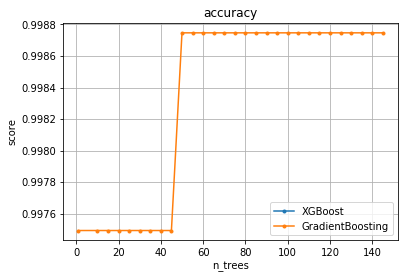

In [85]:
import pylab

pylab.plot(n_trees, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.plot(n_trees, gb_scoring.mean(axis = 1), marker='.', label='GradientBoosting')
pylab.grid(True)
pylab.xlabel('n_trees')
pylab.ylabel('score')
pylab.title('accuracy')
pylab.legend(loc='lower right')

In [137]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

estimator_xgb = xgb.XGBClassifier(learning_rate=0.2, max_depth=60, n_estimators=60, min_child_weight=5)
estimator_xgb.fit(np.array(X_train), y_train)
prediction = estimator_xgb.predict(np.array(X_test))
#estimator_gb = GradientBoostingClassifier(learning_rate=0.2, max_depth=60, n_estimators=60)
#estimator_gb.fit(np.array(X_train), y_train)
#prediction = estimator_gb.predict(np.array(X_test))
test_score_accuracy = accuracy_score(list(y_test), list(prediction))
test_score_f1 = f1_score(list(y_test), list(prediction), average='micro')
test_score_recall = recall_score(list(y_test), list(prediction), average='micro') 
test_score_precision = precision_score(list(y_test), list(prediction), average='micro') 
print(test_score_accuracy, test_score_f1, test_score_recall, test_score_precision)

1.0 1.0 1.0 1.0


In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
clf = RandomForestClassifier(n_estimators=80, random_state=42)

In [142]:
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=80,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [91]:
data.head()

,0,1,features,y
0,drive/My Drive/dataset-easy/0000.wav,dm,"[2.169381919016916, 3.390058058416455, 75.9886...",1
1,drive/My Drive/dataset-easy/0001.wav,e,"[4.513895049803692, 0.9926772869944455, 1.3843...",3
2,drive/My Drive/dataset-easy/0002.wav,c,"[113.33505252181617, 6.956102734052182, 3.0014...",2
3,drive/My Drive/dataset-easy/0003.wav,am,"[40.00733236094169, 0.6997663769131763, 0.3389...",0
4,drive/My Drive/dataset-easy/0004.wav,c,"[123.85238086221821, 6.078684154375269, 1.8656...",2


In [0]:
clf.predict(X[:5])

array([1, 3, 2, 0, 2])

In [0]:
hard = []
dir_ = 'drive/My Drive/dataset-hard'
for root, folders, files in os.walk(dir_):
    a = 0
    for f in sorted(files):
        if '3482' in f or '4693' in f:
            #str_ = '{} {}\n'.format(f.split('.')[0], 'dm')
            #the_file.write(str_)
            continue
        #str_ = '{} {}\n'.format(f.split('.')[0], map_labels[get_chord(os.path.join(dir_, f))])
        #print(str_)
        #the_file.write(str_)
        hard.append([f, get_chord(os.path.join(dir_, f))])
        if a > 100:
          break
        a += 1

In [97]:
len(hard)

102

In [0]:
hard = pd.DataFrame(hard)

In [99]:
hard.head()

,0,1
0,0000.wav,"[7.22783944862735, 24.136698252411325, 23.0919..."
1,0001.wav,"[51.29283825957494, 14.652621460118475, 8.9166..."
2,0002.wav,"[63.126117369567766, 53.29171667392426, 93.316..."
3,0003.wav,"[26.315855365364445, 14.394617230951422, 82.66..."
4,0004.wav,"[28.96086286196617, 15.074509466148534, 8.1362..."


In [0]:
hard.to_pickle('hard_pickle_easy.csv')

In [0]:
hard = pd.read_pickle("drive/My Drive/hard_pickle_easy.csv")

In [103]:
hard.head()

,0,1
0,0000.wav,"[7.22783944862735, 24.136698252411325, 23.0919..."
1,0001.wav,"[51.29283825957494, 14.652621460118475, 8.9166..."
2,0002.wav,"[63.126117369567766, 53.29171667392426, 93.316..."
3,0003.wav,"[26.315855365364445, 14.394617230951422, 82.66..."
4,0004.wav,"[28.96086286196617, 15.074509466148534, 8.1362..."


In [13]:
hard.shape

(5007, 2)

In [113]:
from sklearn.svm import SVC

X = list(data.features.values)
y = data.y.values

clf = SVC(C=0.000001)
clf.fit(X, y)

SVC(C=1e-06, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
# from xgboost import XGBRegressor, XGBClassifier

# clf = XGBClassifier()
# clf.fit(np.array(X), y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
hard[1]

In [0]:
X_pred = list(hard[1].values)
hard['pred_rf'] = clf.predict(X_pred)

In [0]:
prediction_gb = hard["pred_gb"]

In [161]:
prediction_gb

0      1
1      3
2      3
3      3
4      3
      ..
97     1
98     2
99     1
100    3
101    0
Name: pred_gb, Length: 102, dtype: int64

In [0]:
prediction_xgb = hard["pred_xgb"]

In [162]:
prediction_xgb

0      1
1      1
2      3
3      3
4      3
      ..
97     1
98     2
99     1
100    3
101    0
Name: pred_xgb, Length: 102, dtype: int64

In [0]:
prediction_rf = hard["pred_rf"]

In [165]:
prediction_rf

0      1
1      0
2      4
3      4
4      3
      ..
97     1
98     2
99     2
100    4
101    0
Name: pred_rf, Length: 102, dtype: int64

In [127]:
ans = hard[[0, 'pred']]
ans.head()

,0,pred
0,0000.wav,1
1,0001.wav,1
2,0002.wav,3
3,0003.wav,3
4,0004.wav,3


In [0]:
ans =  pd.concat([hard[[0]], prediction_gb, prediction_xgb, prediction_rf], axis = 1)

In [167]:
ans

,0,pred_gb,pred_xgb,pred_rf
0,0000.wav,1,1,1
1,0001.wav,3,1,0
2,0002.wav,3,3,4
3,0003.wav,3,3,4
4,0004.wav,3,3,3
...,...,...,...,...
97,0097.wav,1,1,1
98,0098.wav,2,2,2
99,0099.wav,1,1,2
100,0100.wav,3,3,4


In [168]:
ans['ac_gb'] = ans['pred_gb'].apply(lambda x: i2class[x])
ans['ac_xgb'] = ans['pred_xgb'].apply(lambda x: i2class[x])
ans['ac_rf'] = ans['pred_rf'].apply(lambda x: i2class[x])
ans.head()

,0,pred_gb,pred_xgb,pred_rf,ac_gb,ac_xgb,ac_rf
0,0000.wav,1,1,1,dm,dm,dm
1,0001.wav,3,1,0,e,dm,am
2,0002.wav,3,3,4,e,e,g
3,0003.wav,3,3,4,e,e,g
4,0004.wav,3,3,3,e,e,e


In [129]:
ans['id'] = ans[0].apply(lambda x: x.split('.')[0])
ans.head()

,0,pred,ac,id
0,0000.wav,1,dm,0000
1,0001.wav,1,dm,0001
2,0002.wav,3,e,0002
3,0003.wav,3,e,0003
4,0004.wav,3,e,0004


In [0]:
print_ = ans[['id', 'ac']]
print_.to_csv('hard_ans_rf.txt', sep=' ', index=False)

In [0]:
ans.to_csv("answers.csv")

In [0]:
ans = pd.read_csv("drive/My Drive/answers.csv")

In [171]:
ans.head()

,Unnamed: 0,0,pred_gb,pred_xgb,pred_rf,ac_gb,ac_xgb,ac_rf
0,0,0000.wav,1,1,1,dm,dm,dm
1,1,0001.wav,3,1,0,e,dm,am
2,2,0002.wav,3,3,4,e,e,g
3,3,0003.wav,3,3,4,e,e,g
4,4,0004.wav,3,3,3,e,e,e


In [185]:
a = 0
for idx, st in ans.iterrows():
  if st["pred_gb"] == st['pred_xgb'] == st["pred_rf"]:
    a += 1
print(a)

62


In [186]:
for idx, st in ans.iterrows():
  if not (st["pred_gb"] == st['pred_xgb'] == st["pred_rf"]):
    print(st)

Unnamed: 0           1
0             0001.wav
pred_gb              3
pred_xgb             1
pred_rf              0
ac_gb                e
ac_xgb              dm
ac_rf               am
Name: 1, dtype: object
Unnamed: 0           2
0             0002.wav
pred_gb              3
pred_xgb             3
pred_rf              4
ac_gb                e
ac_xgb               e
ac_rf                g
Name: 2, dtype: object
Unnamed: 0           3
0             0003.wav
pred_gb              3
pred_xgb             3
pred_rf              4
ac_gb                e
ac_xgb               e
ac_rf                g
Name: 3, dtype: object
Unnamed: 0           5
0             0005.wav
pred_gb              1
pred_xgb             1
pred_rf              0
ac_gb               dm
ac_xgb              dm
ac_rf               am
Name: 5, dtype: object
Unnamed: 0           7
0             0007.wav
pred_gb              0
pred_xgb             0
pred_rf              2
ac_gb               am
ac_xgb              am
ac_rf      